# Visualize dynophores: 2D ligand view

In this notebook, we will show how to view the dynophore's superfeatures mapped onto a 2D view of the structure-bound ligand. This visualization uses the [`rdkit` library](https://www.rdkit.org/docs/index.html).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from dynophores import Dynophore
from dynophores.viz import view2d

## Set paths to data files

In [3]:
DATA = Path("../../dynophores/tests/data")
dyno_path = DATA / "out"
pdb_path = DATA / "in/startframe.pdb"

## Load data as `Dynophore` object

In [4]:
dynophore = Dynophore.from_dir(dyno_path)

['AR[4614,4623,4621,4615,4622,4613]', 'HBA[4596]', 'HBA[4606]', 'HBA[4619]', 'HBD[4612]', 'H[4599,4602,4601,4608,4609,4600]', 'H[4615,4623,4622,4613,4621,4614]']
['AR[4614,4623,4621,4615,4622,4613]', 'HBA[4596]', 'HBA[4606]', 'HBA[4619]', 'HBD[4612]', 'H[4599,4602,4601,4608,4609,4600]', 'H[4615,4623,4622,4613,4621,4614]']


## Show 2D ligand view

### Static view

Note that you can toogle the superfeature highlights and PDB serial atom numbers on or off.

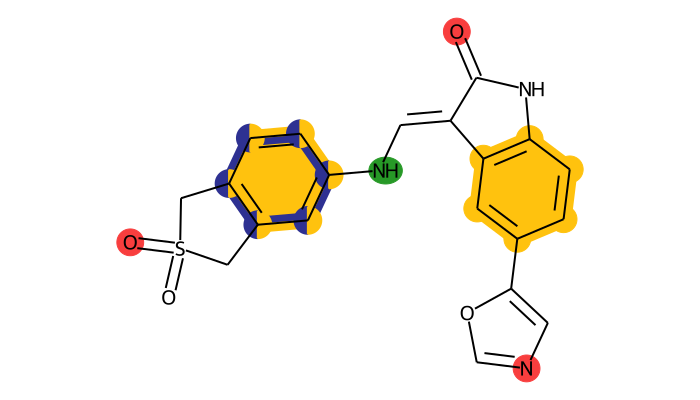

In [7]:
view2d.static.show(dynophore, show_superfeatures=True, show_pdb_serial_numbers=False)

### Interactive view

In [8]:
view2d.interactive.show(dynophore);

interactive(children=(Checkbox(value=False, description='Show superfeatures'), Checkbox(value=False, descripti…